# Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

در این بخش کتابخانه‌هایی که در این پروژ به ‌کار رفته است را به فایل اضافه می کنیم.

In [170]:
# Import required packages
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from xgboost import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import *
from sklearn.metrics import roc_auc_score

سپس فایل مورد نظر را با استفاده از کتابخانه pandas میخوانیم.

In [171]:
# Read CSV file and remove junk data
df = pd.read_csv('/content/drive/MyDrive/diabetes.csv')
df = df.iloc[: , 1:]

# مرحله پیشپردازش
در بخشی از کد مطابق با خواسته شروع به حذف فاصله و جایگزینی آن با _ می‌کنیم.

In [172]:
# Replace blank spaces with underscore.
df.columns = df.columns.str.replace(' ','_')
df = df.replace(' ', '_', regex=True)

در این مرحله آن دسته از فایل‌هایی را که nan value هستند حذف می‌کنیم و آن را با مقدار ردیف قبلی‌اش جایگزین میکنیم.

In [173]:
# Replace nan and Unknown values with previous value in the same column.
for column in df[df.columns[2:]]:
    df[column] = df[column].fillna(method='ffill')
    df[column] = df[column].replace(to_replace='Unknown', method='ffill')

۴ ستون هستند که در اینجا نیاز به normalize شدن دارند. آنها را انتخاب کرده و سپس normalize می‌کنیم.
روش به کار رفته در اینجا min-max می‌باشد.

In [174]:
# Nomalize column'a data.
cols_to_be_normalized = ['BMI', 'Physical_Health', 'Mental_Health', 'Age']
for cols in cols_to_be_normalized:
  df[cols] = (df[cols] - df[cols].min()) / (df[cols].max() - df[cols].min())

در این بخش به سراغ فایل می‌اییم و آن داد‌هایی را که به صورت categorigal هستند به مقادیر عددی تبدیل می‌کنیم.
روش به کار روش هم one-hot-encoding می‌باشد.

In [175]:
# Use one-hot-encoding to convert categorical data to numerical data.
cat_cols = df.select_dtypes(include=[object]).columns.to_list()
for col in cat_cols:
  df = df.join(pd.get_dummies(df[col], prefix=col))
  df.drop(col, axis=1, inplace=True)

# ساخت مدل طبقه بند
XGBClassifier ماژولی از xgboost است که از آن برای ساخت مدل classification استفاده میکنیم.

In [176]:
# Build a classification model
label = df[["Diabetes_binary"]]
df = df.drop('Diabetes_binary', 1)
df = df.iloc[:, :].values
label = label.iloc[:, :].values
x_train, x_test, y_train, y_test = train_test_split(df, label, test_size=0.3, random_state=1)
y_train = y_train.ravel()
y_test = y_test.ravel()
xgbc = XGBClassifier(learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.5, colsample_bytree=1,
                        random_seed=123, eval_metric='auc', verbosity=1, early_stopping_rounds=10)
xgbc.fit(x_train, y_train)
y_pred = xgbc.predict(x_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


accuracy_score هم برای محاسبه دقت مدل آموزش استفاده شده است.

In [178]:
# Calculate accuracy of model
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7555167861184459

ماتریس درهم‌ریختگی را برای مدل می‌سازیم و نمایشش می‌دهیم.

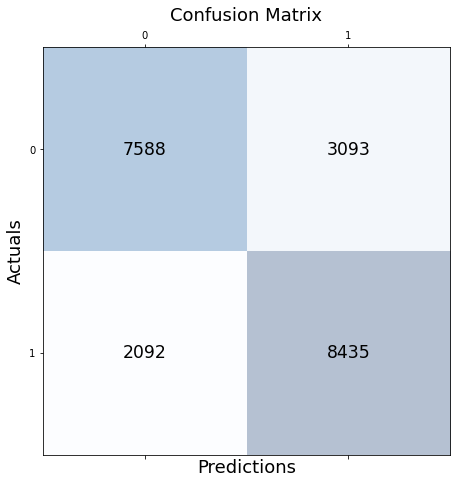

In [179]:
# Plot confusion matrix using matplotlib
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

مقدار precision و recall را به دست می‌آوریم.

In [181]:
# Returning the value of precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred)
precision, recall

(array([0.49636929, 0.73169674, 1.        ]),
 array([1.        , 0.80127292, 0.        ]))

# تنظیم هایپرپارامترها
تابع امتیازدهی مطابق خواسته سوال

In [182]:
# Scoring function
def my_roc_auc_score(model, x, y):
  return roc_auc_score(y, model.predict_proba(x)[:, 1])

xgboost.XGBClassifier هم برای ساخت مدل استفاده شده است و پارامتر‌های مورد نظر را به ‌ان می‌دهیم.

In [183]:
# Create GridSearchCV model
param_grid = {'learning_rate': [0.02, 0.05, 0.1, 0.3], 'max_depth': [2, 3, 4], 'n_estimators': [100, 200, 300], 'colsample_bytree': [0.8, 1]}
gscv = GridSearchCV(xgbc, param_grid, cv=3, scoring=my_roc_auc_score)
gscv.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(early_stopping_rounds=10,
                                     eval_metric='auc', max_depth=4,
                                     n_estimators=200, random_seed=123,
                                     subsample=0.5),
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.02, 0.05, 0.1, 0.3],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [100, 200, 300]},
             scoring=<function my_roc_auc_score at 0x7f5e85911830>)

مقادیر مربوط به best score و best parameters را به عنوان خروجی نمایش می‌دهیم.

In [184]:
# Returning the value of best score & best parameters
print('Best score -> ', gscv.best_score_)
print('Best parameters -> ', gscv.best_params_)

Best score ->  0.8289493455482391
Best parameters ->  {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200}


دقت مدل را محاسبه می‌کنیم.

In [185]:
# Calculate accuracy of model
y_pred = gscv.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7565069784986798

نمایش ماتریس درهم‌ریختگی

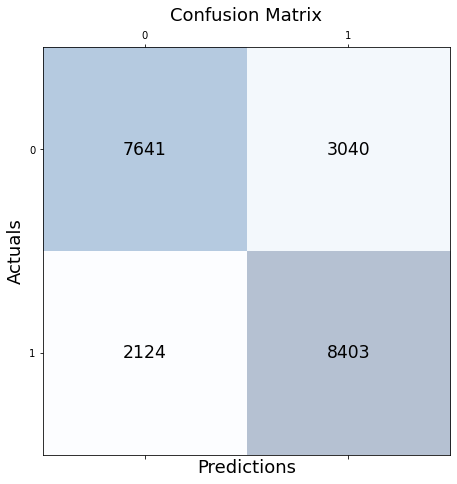

In [186]:
# Plot confusion matrix using matplotlib
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

precison و recall را به دست می‌آوریم.

In [187]:
# Returning the value of precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred)
precision, recall

(array([0.49636929, 0.7343354 , 1.        ]),
 array([1.        , 0.79823311, 0.        ]))

In [218]:
# Parameters
learning_rate = [0.02, 0.05, 0.1, 0.3] 
max_depth = [2, 3, 4] 
n_estimators = [100, 200, 300]
colsample_bytree = [0.8, 1]

# تصویر سازی تغییر هایپرپارامترها
تصویر سازی تغییر هایپرپارامترها هم مطابق با خواسته در این مرحله نمایش داده می‌شود.

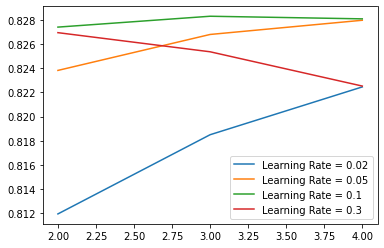

In [223]:
# Illustration of changing hyperparameters
line1, line2, line3, line4 = [], [], [], []
legend_value = ['Learning Rate = 0.02', 'Learning Rate = 0.05', 'Learning Rate = 0.1', 'Learning Rate = 0.3']
for index, value in enumerate(gscv.cv_results_['params']):
  if value['n_estimators'] == n_estimators[0] and value['colsample_bytree'] == colsample_bytree[0] and value['learning_rate'] == learning_rate[0]:
    line1.append(gscv.cv_results_['mean_test_score'][index])
  if value['n_estimators'] == n_estimators[0] and value['colsample_bytree'] == colsample_bytree[0] and value['learning_rate'] == learning_rate[1]:
    line2.append(gscv.cv_results_['mean_test_score'][index])
  if value['n_estimators'] == n_estimators[0] and value['colsample_bytree'] == colsample_bytree[0] and value['learning_rate'] == learning_rate[2]:
    line3.append(gscv.cv_results_['mean_test_score'][index])
  if value['n_estimators'] == n_estimators[0] and value['colsample_bytree'] == colsample_bytree[0] and value['learning_rate'] == learning_rate[3]:
    line4.append(gscv.cv_results_['mean_test_score'][index])
plt.plot(max_depth, line1)
plt.plot(max_depth, line2)
plt.plot(max_depth, line3)
plt.plot(max_depth, line4)
plt.legend(legend_value)
plt.show()

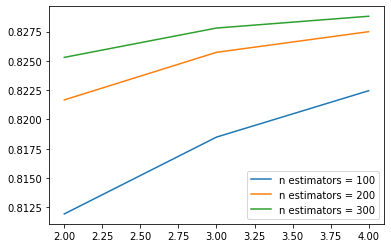

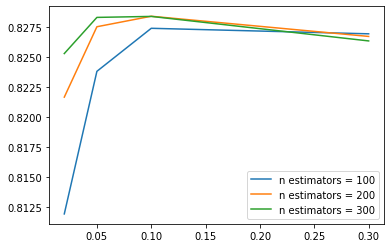

In [230]:
line1, line2, line3 = [], [], []
legend_value = ['n estimators = 100', 'n estimators = 200', 'n estimators = 300']
for index, value in enumerate(gscv.cv_results_['params']):
  if value['learning_rate'] == learning_rate[0] and value['colsample_bytree'] == colsample_bytree[0] and value['n_estimators'] == n_estimators[0]:
    line1.append(gscv.cv_results_['mean_test_score'][index])
  if value['learning_rate'] == learning_rate[0] and value['colsample_bytree'] == colsample_bytree[0] and value['n_estimators'] == n_estimators[1]:
    line2.append(gscv.cv_results_['mean_test_score'][index])
  if value['learning_rate'] == learning_rate[0] and value['colsample_bytree'] == colsample_bytree[0] and value['n_estimators'] == n_estimators[2]:
    line3.append(gscv.cv_results_['mean_test_score'][index])


plt.plot(max_depth, line1)
plt.plot(max_depth, line2)
plt.plot(max_depth, line3)
plt.legend(legend_value)
plt.show()


line1, line2, line3 = [], [], []
for index, value in enumerate(gscv.cv_results_['params']):
  if value['colsample_bytree'] == 0.8 and value['max_depth'] == 2 and value['n_estimators'] == 100:
    line1.append(gscv.cv_results_['mean_test_score'][index])
  if value['colsample_bytree'] == 0.8 and value['max_depth'] == 2 and value['n_estimators'] == 200:
    line2.append(gscv.cv_results_['mean_test_score'][index])
  if value['colsample_bytree'] == 0.8 and value['max_depth'] == 2 and value['n_estimators'] == 300:
    line3.append(gscv.cv_results_['mean_test_score'][index])

plt.plot(learning_rate, line1)
plt.plot(learning_rate, line2)
plt.plot(learning_rate, line3)
plt.legend(legend_value)
plt.show()

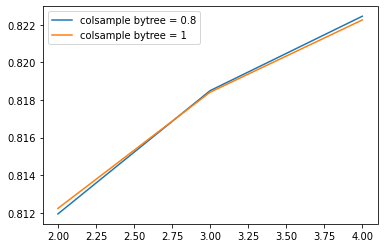

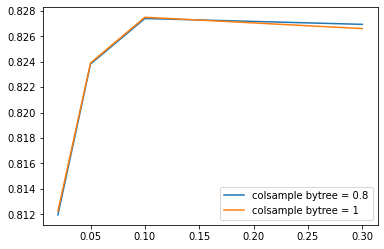

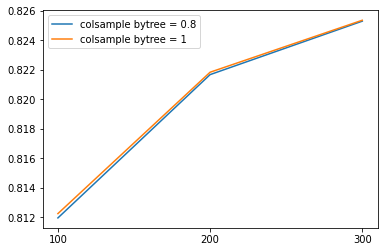

In [236]:
line1, line2 = [], []
legend_value = ['colsample bytree = 0.8', 'colsample bytree = 1']
for index, res in enumerate(gscv.cv_results_['params']):
  if res['learning_rate'] == 0.02 and res['n_estimators'] == 100 and res['colsample_bytree'] == 0.8:
    line1.append(gscv.cv_results_['mean_test_score'][index])
  if res['learning_rate'] == 0.02 and res['n_estimators'] == 100 and res['colsample_bytree'] == 1:
    line2.append(gscv.cv_results_['mean_test_score'][index])


plt.plot(max_depth, line1)
plt.plot(max_depth, line2)
plt.legend(legend_value)
plt.show()


line1, line2 = [], []
for index, res in enumerate(gscv.cv_results_['params']):
  if res['n_estimators'] == n_estimators[0] and res['max_depth'] == max_depth[0] and res['colsample_bytree'] == colsample_bytree[0]:
    line1.append(gscv.cv_results_['mean_test_score'][index])
  if res['n_estimators'] == n_estimators[0] and res['max_depth'] == max_depth[0] and res['colsample_bytree'] == colsample_bytree[1]:
    line2.append(gscv.cv_results_['mean_test_score'][index])

plt.plot(learning_rate, line1)
plt.plot(learning_rate, line2)
plt.legend(legend_value)
plt.show()


line1, line2 = [], []
for index, res in enumerate(gscv.cv_results_['params']):
  if res['learning_rate'] == learning_rate[0] and res['max_depth'] == max_depth[0] and res['colsample_bytree'] == colsample_bytree[0]:
    line1.append(gscv.cv_results_['mean_test_score'][index])
  if res['learning_rate'] == learning_rate[0] and res['max_depth'] == max_depth[0] and res['colsample_bytree'] == colsample_bytree[1]:
    line2.append(gscv.cv_results_['mean_test_score'][index])

plt.plot(n_estimators, line1)
plt.plot(n_estimators, line2)
plt.legend(legend_value)
plt.xticks(n_estimators)
plt.show()